# Simulazioni {#sec-simulations}

**Prerequisiti**

- Leggere [Regression and Other Stories](https://users.aalto.fi/~ave/ROS.pdf). Focalizzati sul capitolo 5. 

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import seaborn as sns

In [18]:
seed: int = sum(map(ord, "simulation"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione

In questo capitolo discuteremo alcuni degli esercizi di simulazione presentati da @gelman2021regression nel quinto capitolo del loro libro. Gli autori introducono la pratica della simulazione affermando che simulare variabili casuali è fondamentale nelle statistiche applicate per vari motivi. 

In primo luogo, utilizziamo modelli di probabilità per imitare la variazione nel mondo reale, e gli strumenti di simulazione ci aiutano a comprendere meglio come questa variazione si manifesti. I modelli di casualità spesso contraddicono il pensiero umano comune: i nostri cervelli faticano a comprendere che le oscillazioni casuali sono presenti nel breve termine ma si livellano nel lungo termine. In molti casi, la simulazione è di grande aiuto per allenare le nostre intuizioni riguardo agli andamenti medi e alla variazione.

In secondo luogo, possiamo utilizzare la simulazione per approssimare la distribuzione campionaria dei dati e trasferire questa approssimazione alla distribuzione campionaria delle stime e delle procedure statistiche. 

Infine, i modelli di regressione non sono deterministici, ma producono previsioni probabilistiche. La simulazione è il metodo più conveniente e generale per rappresentare le incertezze nelle previsioni.

## Simulazione di Modelli di Probabilità Discreti

Il primo esercizio discusso da @gelman2021regression cerca di rispondere alla seguente domanda: Quante bambine su 400 nascite?

La probabilità che un neonato sia una bambina o un bambino è approssimativamente del 48.8% o 51.2%, rispettivamente, e queste percentuali non variano molto in tutto il mondo. Supponiamo che in un anno nascano 400 bambini in un ospedale. Quante saranno bambine?

@gelman2021regression mostrano come possiamo rispondere a questa domanda simulando le 400 nascite utilizzando la distribuzione binomiale e ripetendo la simulazione 10,000 volte.

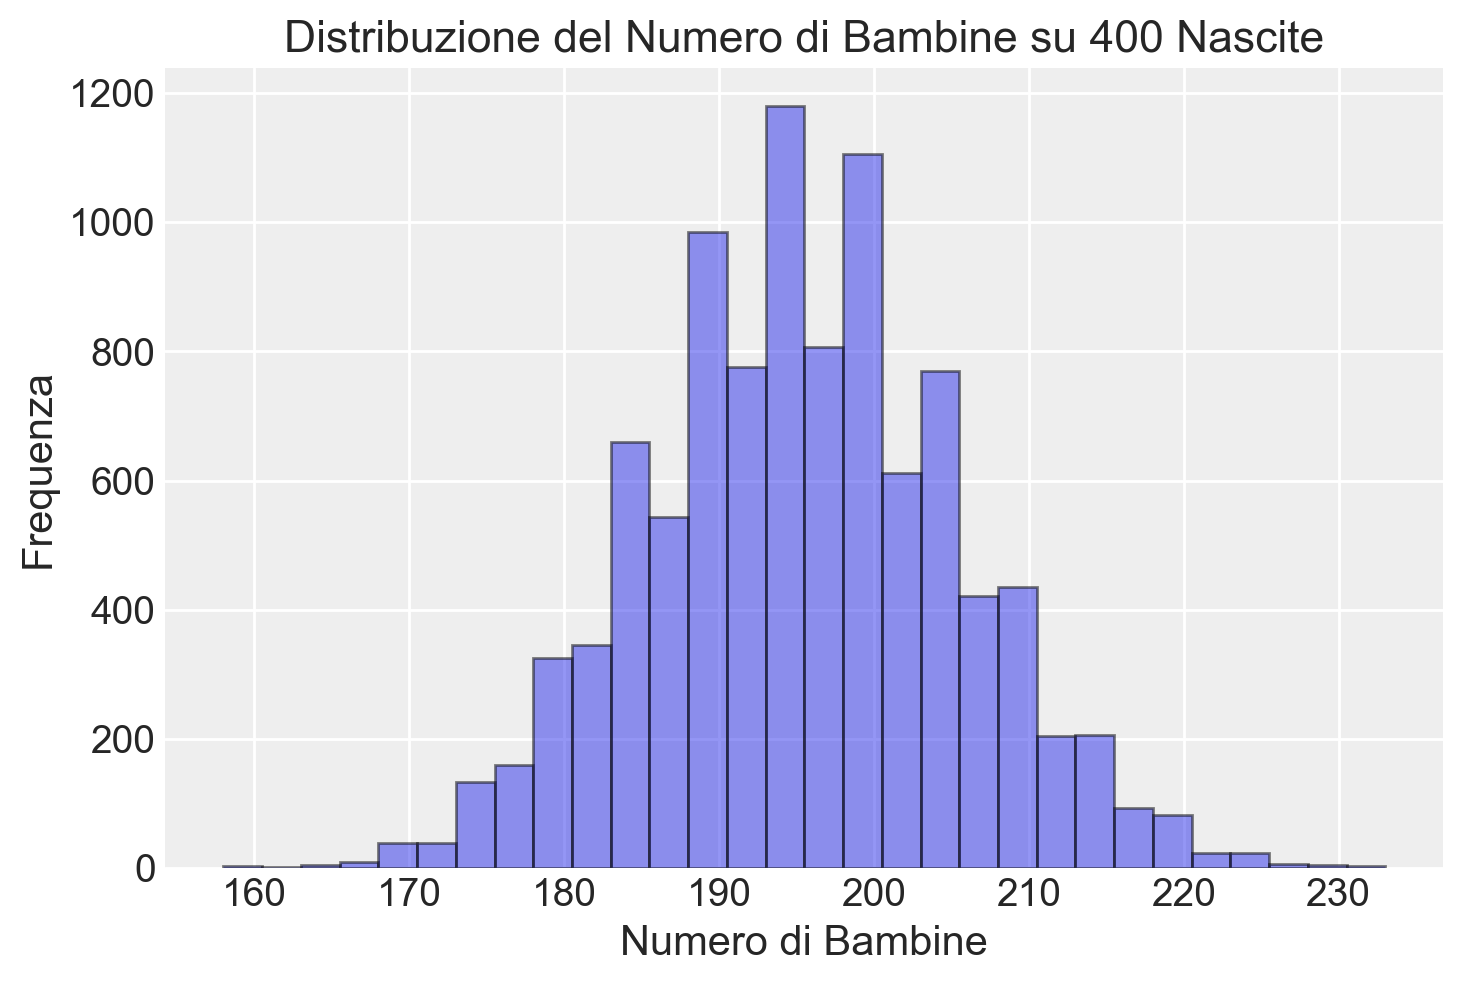

In [44]:
# Numero di simulazioni
n_sims = 10_000

# Probabilità di avere una bambina
p_girl = 0.488

# Simulazione delle nascite
n_girls = np.random.binomial(n=400, p=p_girl, size=n_sims)

# Visualizzazione dell'istogramma
plt.hist(n_girls, bins=30, edgecolor="black", alpha=0.5)
plt.title('Distribuzione del Numero di Bambine su 400 Nascite')
plt.xlabel('Numero di Bambine')
plt.ylabel('Frequenza')
plt.show()

Possiamo complicare il modello in diversi modi. Ad esempio, c'è una probabilità di 1 su 125 che un evento di nascita risulti in gemelli dizigoti, ciascuno dei quali ha una probabilità approssimativa del 49.5% di essere una bambina, e una probabilità di 1 su 300 di gemelli monozigoti, che hanno una probabilità approssimativa del 49.5% di essere entrambe bambine. Possiamo simulare 400 eventi di nascita nel modo seguente:

In [45]:
# Probabilità per i tipi di nascita
probabilities = [1/125, 1/300, 1 - 1/125 - 1/300]

# Tipi di nascita
birth_types = ["fraternal twin", "identical twin", "single birth"]

# Simulazione dei tipi di nascita per 400 eventi
birth_type = np.random.choice(birth_types, size=400, p=probabilities)

# Array per memorizzare il numero di bambine
girls = np.empty(400)

# Ciclo per determinare il numero di bambine in base al tipo di nascita
for i in range(400):
    if birth_type[i] == "single birth":
        girls[i] = np.random.binomial(1, 0.488)
    elif birth_type[i] == "identical twin":
        girls[i] = 2 * np.random.binomial(1, 0.495)
    elif birth_type[i] == "fraternal twin":
        girls[i] = np.random.binomial(2, 0.495)

# Somma totale delle bambine
n_girls = np.sum(girls)

print(n_girls)

194.0


Nel codice, identifichiamo tre categorie di nascita: gemelli dizigoti, gemelli monozigoti e nascite singole, e assegnamo le probabilità specificate dal problema a ciascun tipo di nascita. Campioniamo in maniera casuale da tale distribuzione di probabilità discreta ottenendo il vettore `birth_type` di 400 elementi. Nel ciclo `for`, esaminiamo ciascuno dei 400 elementi di `birth_type`. Se il tipo di nascita è `single birth`, generiamo un valore casuale dalla distribuzione binomiale con probabilità di successo $p$ pari a 0,488. Se il tipo di nascita è `identical twin`, generiamo un valore casuale dalla distribuzione binomiale con $p$ pari a 0,495 e moltiplichiamo per 2 per rappresentare entrambe le gemelle. Se il tipo di nascita è `fraternal twin`, generiamo un valore casuale dalla distribuzione binomiale con $p$ pari a 0,495 per due nascite.

Usciti dal ciclo, sommiamo il numero di `1` nel vettore `girls` per ottenere una stima del numero di bambine nate.

Invece di utilizzare un ciclo `for` per 400 iterazioni, è possibile generare 400 eventi dalla distribuzione binomiale con una singola istruzione, come mostrato nel codice seguente.

In [46]:
# Determinazione del numero di bambine per ogni tipo di nascita
girls = np.where(birth_type == "single birth", 
                 np.random.binomial(1, 0.488, 400),
                 np.where(birth_type == "identical twin", 
                          2 * np.random.binomial(1, 0.495, 400),
                          np.random.binomial(2, 0.495, 400)))

# Somma totale delle bambine
n_girls = np.sum(girls)

print(n_girls)


199


Anche in questo secondo caso otteniamo un risultato simile al precedente. Poiché si tratta di una simulazione basata su numeri casuali, il risultato numerico esatto varia ad ogni esecuzione della simulazione. Per comprendere l'incertezza associata alla simulazione, possiamo ripetere l'intero processo un gran numero di volte (in questo caso, 10,000 volte).

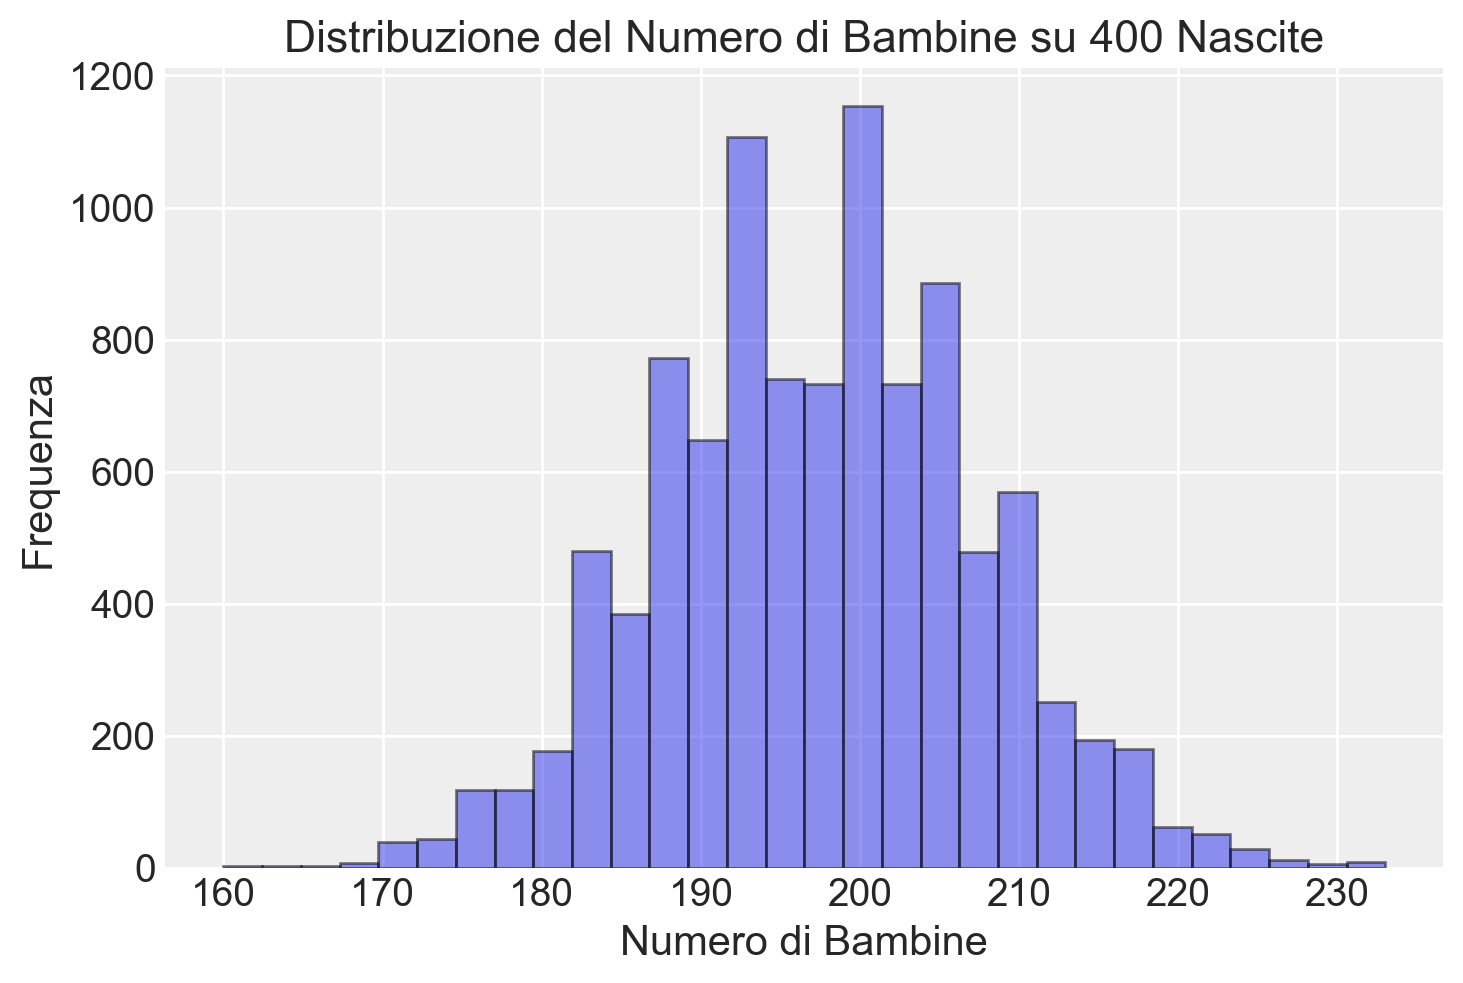

In [47]:
n_sims = 10_000

# Array per memorizzare il numero di bambine per ogni simulazione
n_girls = np.zeros(n_sims)

# Eseguiamo 10.000 simulazioni
for s in range(n_sims):
    # Simulazione dei tipi di nascita per 400 eventi
    birth_type = np.random.choice(birth_types, size=400, p=probabilities)

    # Array per memorizzare il numero di bambine per ogni evento di nascita
    girls = np.zeros(400)

    # Determiniamo il numero di bambine in base al tipo di nascita
    for i in range(400):
        if birth_type[i] == "single birth":
            girls[i] = np.random.binomial(1, 0.488)
        elif birth_type[i] == "identical twin":
            girls[i] = 2 * np.random.binomial(1, 0.495)
        elif birth_type[i] == "fraternal twin":
            girls[i] = np.random.binomial(2, 0.495)

    # Sommiamo il numero di bambine per questa simulazione
    n_girls[s] = np.sum(girls)

# Visualizzazione dell'istogramma
plt.hist(n_girls, bins=30, edgecolor="black", alpha=0.5)
plt.title("Distribuzione del Numero di Bambine su 400 Nascite")
plt.xlabel("Numero di Bambine")
plt.ylabel("Frequenza")
plt.show()

## Simulazione di probabilità continue

@gelman2021regression dimostrano come sia possibile incorporare anche distribuzioni di probabilità continue nei tipi di simulazioni discusse nella sezione precedente. Forniscono il seguente esempio di un modello misto discreto/continuo: il 52% degli adulti negli Stati Uniti sono donne e il 48% sono uomini. L'altezza degli uomini segue approssimativamente una distribuzione normale con una media di 69.1 pollici e una deviazione standard di 2.9 pollici; per le donne, la media è 63.7 pollici e la deviazione standard è 2.7 pollici. Ecco il codice per generare l'altezza di un adulto scelto casualmente:

In [48]:
# Funzione per simulare l'altezza media
def height_sim(N):
    male = np.random.binomial(1, 0.48, N)
    height = np.where(male == 1, np.random.normal(69.1, 2.9, N), np.random.normal(63.7, 2.7, N))
    return np.mean(height)

Supponiamo di selezionare 10 adulti a caso. Cosa possiamo dire della loro altezza media?

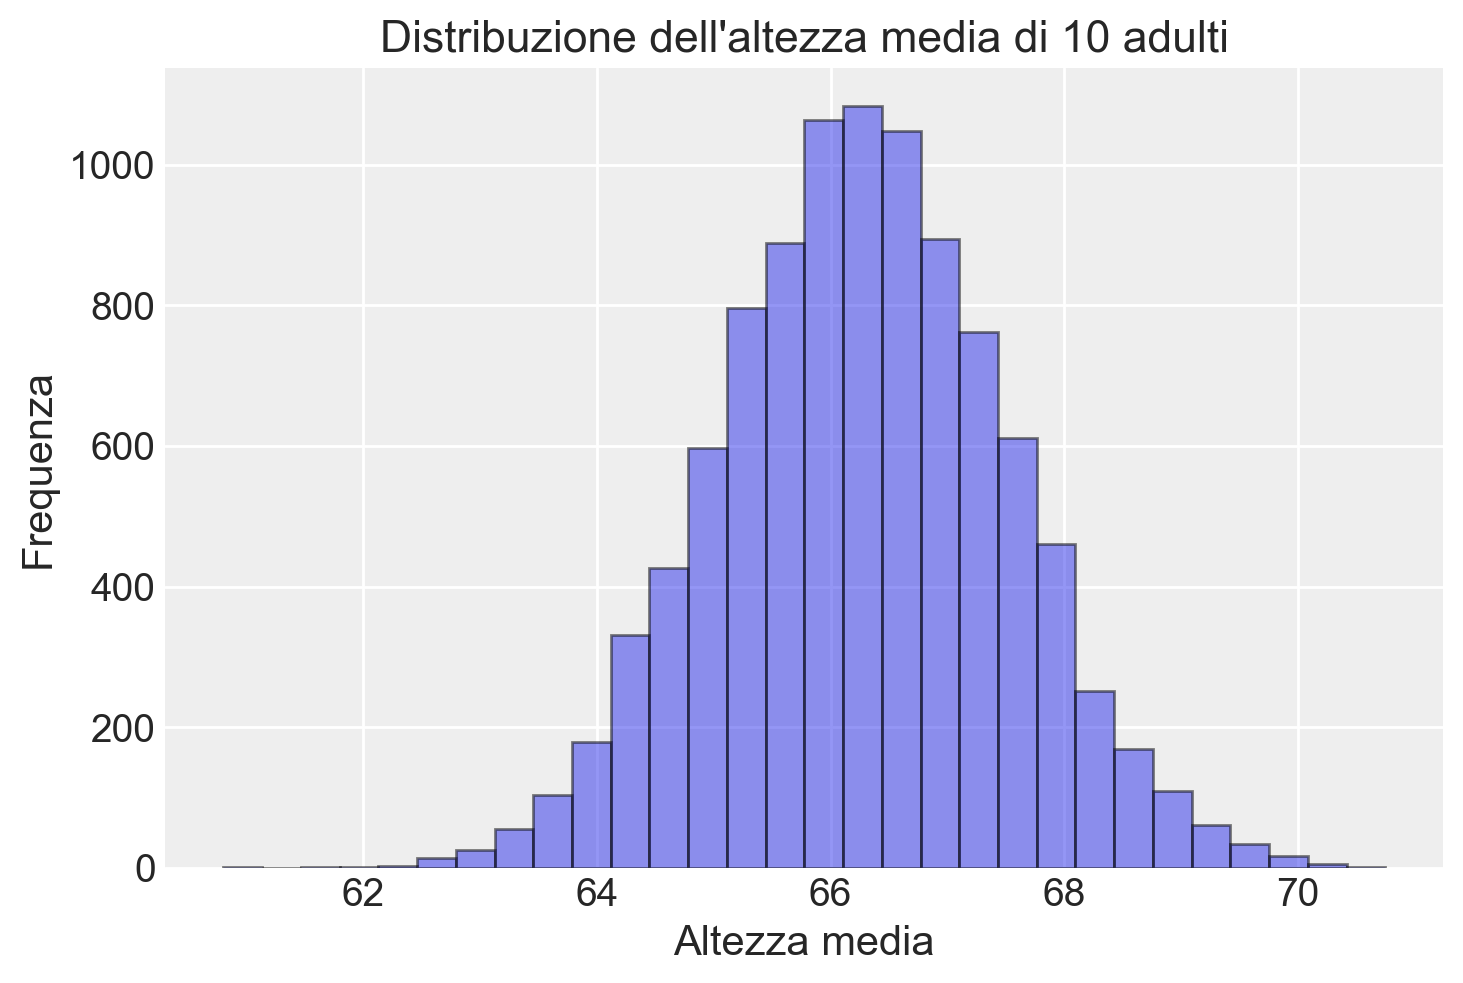

In [49]:
# Numero di simulazioni
n_sims = 10_000

# Array per memorizzare le altezze medie
avg_height = np.empty(n_sims)
max_height = np.empty(n_sims)

# Eseguiamo 10000 simulazioni
for s in range(n_sims):
    N = 10
    male = np.random.binomial(1, 0.48, N)
    height = np.where(male == 1, np.random.normal(69.1, 2.9, N), np.random.normal(63.7, 2.7, N))
    avg_height[s] = np.mean(height)
    max_height[s] = np.max(height)

# Istogramma delle altezze medie
plt.hist(avg_height, bins=30, edgecolor='black', alpha=0.5)
plt.title('Distribuzione dell\'altezza media di 10 adulti')
plt.xlabel('Altezza media')
plt.ylabel('Frequenza')
plt.show()

Cosa possiamo dire dell'altezza massima delle 10 persone? 

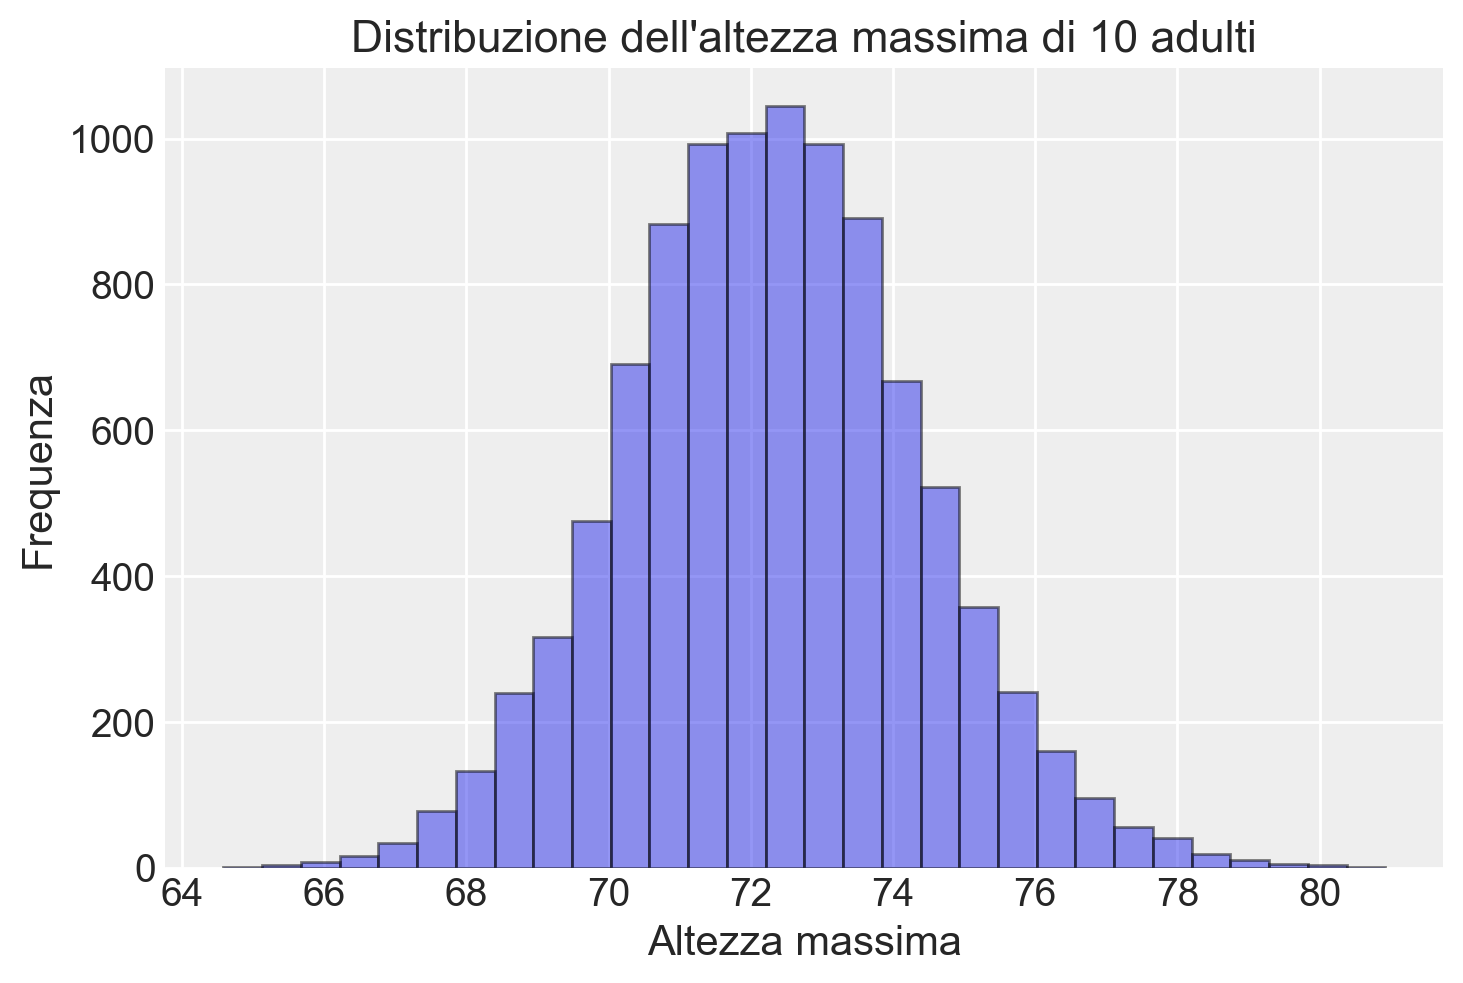

In [50]:
# Istogramma delle altezze massime
plt.hist(max_height, bins=30, edgecolor='black', alpha=0.5)
plt.title('Distribuzione dell\'altezza massima di 10 adulti')
plt.xlabel('Altezza massima')
plt.ylabel('Frequenza')
plt.show()

## Sommario di una simulazione con media e mediana

Quando le nostre distribuzioni sono costruite come simulazioni al computer, può essere conveniente riassumerle in qualche modo. Tipicamente, riassumiamo la posizione di una distribuzione con la sua media o mediana, che possiamo calcolare direttamente in Python utilizzando `numpy`.

La variazione nella distribuzione è tipicamente riassunta dalla deviazione standard (in Python, calcolata utilizzando `numpy.std`), ma spesso preferiamo usare la deviazione mediana assoluta. Se la mediana di un insieme di simulazioni $z_1, \ldots, z_n$ è $M$, allora la deviazione mediana assoluta è:

$$ \text{mad} = \text{mediana}_{n} |z_i - M| $$

Tuttavia, poiché siamo abituati a lavorare con le deviazioni standard, quando calcoliamo la deviazione mediana assoluta, la riscaliamo moltiplicandola per 1.483, il che riproduce la deviazione standard nel caso speciale della distribuzione normale. Chiamiamo questa la "mad sd" e può essere calcolata in Python come:

$$ 1.483 * \text{median}(|y - \text{median}(z)|) $$

Preferiamo tipicamente i riassunti basati sulla mediana perché sono più stabili computazionalmente, e riscaliamo il riassunto basato sulla mediana della variazione come descritto sopra in modo da essere comparabile alla deviazione standard, che sappiamo già interpretare nella pratica statistica usuale.

### Codice in Python

Ecco come implementare quanto sopra in Python per i dati relativi all'altezza media di 10 adulti.

In [51]:
# Funzione per calcolare la media e la mediana
def summarize_location(data):
    mean_value = np.mean(data)
    median_value = np.median(data)
    return mean_value, median_value

# Funzione per calcolare la deviazione standard
def calculate_sd(data):
    return np.std(data, ddof=1)

# Funzione per calcolare la deviazione mediana assoluta (mad)
def calculate_mad(data):
    median_value = np.median(data)
    mad = np.median(np.abs(data - median_value))
    mad_sd = 1.483 * mad
    return mad, mad_sd

# Esempio di utilizzo
data = avg_height

# Calcolo della media e della mediana
mean_value, median_value = summarize_location(data)
print("Mean:", mean_value)
print("Median:", median_value)

# Calcolo della deviazione standard
sd_value = calculate_sd(data)
print("Standard Deviation:", sd_value)

# Calcolo della deviazione mediana assoluta e mad sd
mad_value, mad_sd_value = calculate_mad(data)
print("MAD:", mad_value)
print("MAD SD:", mad_sd_value)

Mean: 66.26638365143874
Median: 66.26529661442922
Standard Deviation: 1.2304485051822338
MAD: 0.835064693740172
MAD SD: 1.2384009408166752


Infine, possiamo riassumere qualsiasi distribuzione tramite intervalli di incertezza; ad esempio, `quantile(z, 0.25, 0.75)` restituisce un intervallo centrale del 50% e `quantile(z, 0.025, 0.975)` restituisce un intervallo centrale del 95%.

In Python, possiamo usare `numpy` per calcolare i quantili e quindi ottenere gli intervalli di incertezza desiderati. Ecco come fare:

In [52]:
# Funzione per calcolare gli intervalli di incertezza
def uncertainty_intervals(data, lower_quantile, upper_quantile):
    lower = np.quantile(data, lower_quantile)
    upper = np.quantile(data, upper_quantile)
    return lower, upper

# Esempio di utilizzo
data = avg_height

# Calcolo dell'intervallo centrale del 50%
lower_50, upper_50 = uncertainty_intervals(data, 0.25, 0.75)
print("Central 50% interval:", lower_50, "-", upper_50)

# Calcolo dell'intervallo centrale del 95%
lower_95, upper_95 = uncertainty_intervals(data, 0.025, 0.975)
print("Central 95% interval:", lower_95, "-", upper_95)

Central 50% interval: 65.42660984223639 - 67.0950850704999
Central 95% interval: 63.88592362666574 - 68.7170467946227


## Commenti e Considerazioni Finali

Lo scopo della simulazione di dati fittizi non è fornire intuizioni sui dati o sul problema reale in esame, ma piuttosto valutare le proprietà dei metodi statistici utilizzati, partendo da un modello generativo ipotizzato. Le simulazioni sono cruciali nella pratica della ricerca. Molti autori suggeriscono che dovrebbero essere eseguite prima di raccogliere i dati di uno studio, per valutare, tra le altre cose, se la dimensione campionaria prevista fornisce un potere statistico sufficiente per rispondere alla domanda della ricerca [@gelman2024statistical].

## Esercizi

::: {#exr-prob-simulation-1}

Immagina il caso di 220 studenti che devono sostenere tre prove in itinere in un corso. Il voto finale è la media dei voti ottenuti in queste tre prove. Le distribuzioni dei voti per le prove sono descritte come segue:

- Prima prova: I voti sono distribuiti secondo una gaussiana con media 24. Il 15% degli studenti ottiene un voto inferiore a 18.
- Seconda prova: I voti sono distribuiti secondo una gaussiana con media 25. Il 10% degli studenti ottiene un voto inferiore a 18.
- Terza prova: I voti sono distribuiti secondo una gaussiana con media 26. Solo il 5% degli studenti ottiene un voto inferiore a 18.

Dei 220 studenti iniziali:

- Il 10% non partecipa alla prima prova.
- Un ulteriore 5% non partecipa alla seconda prova.

Per ottenere il voto finale, uno studente deve partecipare a tutte e tre le prove.

Utilizzando una simulazione, trova la media finale dei voti e calcola l'intervallo di incertezza al 90% per la stima della media.

:::

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [53]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Thu Aug 08 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
matplotlib: 3.9.1
seaborn   : 0.13.2
arviz     : 0.18.0

Watermark: 2.4.3

